In [1]:
import numpy as np
import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt
import scipy.stats as sc

In [2]:
np.random.seed(1996)

In [5]:
def loadBatch(filename):
	with open('Datasets/'+filename, 'rb') as fo:    
		dict = pickle.load(fo, encoding='bytes')
		
		y = np.asarray(dict[b'labels'])
		
		Y = np.zeros((10000,10))
		Y[np.arange(y.size), y] = 1

		X = np.asarray(dict[b'data'])/255
	
	return X.transpose(),Y.transpose(), y

xTrainNN,yTrain,lTrain = loadBatch("data_batch_1")
xVal,yVal,lVal = loadBatch("data_batch_2")
xTest,yTest,lTest = loadBatch("data_batch_3")

In [23]:
def transformData(xOut, xTrain = xTrainNN):
    mat = (xOut.transpose()-np.mean(xTrain, axis = 1))/np.std(xTrain, axis = 1)
    return mat.transpose()

#Normalized Data
xTrain = transformData(xTrainNN)
xVal = transformData(xVal)
xTest = transformData(xTest)


In [7]:
#Indep
def initializeParam(d, he, batchNorm, sig):
	
	#Layers on the form (out,in)
	
	if he:
		W = np.random.normal(0, 2/np.sqrt(d[1]), (d[0], d[1]))
	else:
		W = np.random.normal(0, sig, d)
	
	b = np.zeros((d[0],1))
	
	if batchNorm:
		gamma = np.ones((d[0],1))
		beta = np.zeros((d[0],1))
		mu = np.zeros((d[0],1))
		v = np.zeros((d[0],1))
		
		return W, b, gamma, beta, mu, v
	
	else:
		
		return W, b

In [8]:
#Problems due to too small values with np.exp
def softMax(x):
    return np.exp(x-np.amax(x))/np.sum(np.exp(x-np.amax(x)), axis = 0)

def relu(h):
    h[h<0] = 0
    return h


In [25]:
#Initializing parameters
class BNN(object):

    def __init__(self, layers, lmda = 0, alpha = 0.8, batchNorm = True, he = True, sig = 1e-1):
        self.layers = layers
        self.nl = len(layers) - 1
        self.W, self.b = [], []
        self.batchNorm = batchNorm
        self.he = he
        self.sig = sig
        self.lmda = lmda

        if batchNorm:
            self.gamma, self.beta, self.muMA, self.vaMA = [],[],[],[]
            self.alpha = alpha
        for layer in self.layers:
            if batchNorm:
                W, b, gamma, beta, mu, v = initializeParam(layer, he, batchNorm, sig)
                self.W.append(W)
                self.b.append(b)
                self.gamma.append(gamma)
                self.beta.append(beta)
                self.muMA.append(mu)
                self.vaMA.append(v)
            else:
                W, b = initializeParam(layer, he, batchNorm, sig)
                self.W.append(W)
                self.b.append(b)

    def zeros(self):
        wl, bl = [], []
        for i in range(len(self.W)):
            W = np.zeros_like(self.W[i])
            b = np.zeros_like(self.b[i])
            wl.append(W)
            bl.append(b)
        if self.batchNorm:
            gl, betal = [], []
            for i in range(len(self.gamma)):
                gamma =  np.zeros_like(self.gamma[i])
                beta =  np.zeros_like(self.beta[i])
                gl.append(gamma)
                betal.append(beta)
            return wl, bl, gl, betal
        else:
            return wl, bl

    def evaluateClassifier(self, X, training = True):
        nb = X.shape[1]
        s = np.copy(X)
        if self.batchNorm:
            sl, shl, hl, mul, vl = [], [], [], [], []
            for i in range(len(self.W)):
                hl.append(s)
                s = np.matmul(self.W[i],s) + self.b[i]
                if i < self.nl:
                    sl.append(s)
                    if training: #Training
                        mu = np.mean(s, axis = 1, keepdims = True)
                        v = np.var(s, axis = 1, keepdims = True)*(nb-1)/nb
                        mul.append(mu)
                        vl.append(v)
                        s = (s - mu)/np.sqrt(v + np.finfo(np.float).eps)
                        self.muMA[i] = self.alpha*self.muMA[i] + (1-self.alpha)*mu
                        self.vaMA[i] = self.alpha*self.vaMA[i] + (1-self.alpha)*v
                    else: #Testing
                        s = (s - self.muMA[i])/np.sqrt(self.vaMA[i] + np.finfo(np.float).eps)
                    shl.append(s)
                    s = relu(np.multiply(s,self.gamma[i]) + self.beta[i])
                else:
                    p = softMax(s)
            return p, hl, sl, shl, mul, vl
        else:
            hl = [s]
            for i in range(len(self.W)-1):
                s = relu(np.matmul(self.W[i], s) + self.b[i])
                hl.append(s)
            p = softMax(np.matmul(self.W[-1], s)+ self.b[-1])
            return p, hl

    def computeGradients(self, X, Y):
        nb = X.shape[1]
        if self.batchNorm:
            gradW, gradB, gradG, gradBeta = self.zeros()
            p, h, s, sh, mu, v = self.evaluateClassifier(X, training = True)
            g = -(Y-p)
            gradW[self.nl] = np.matmul(g,h[self.nl].transpose())/nb + 2*self.lmda*self.W[self.nl]
            gradB[self.nl] = np.matmul(g,np.ones((nb, 1)))/nb
            g = np.matmul(self.W[self.nl].transpose(), g)
            g = np.multiply(g, h[self.nl] > 0)
            for i in range(self.nl - 1, -1, -1):
                gradG[i] = np.matmul(np.multiply(g, sh[i]),np.ones((nb,1)))/nb
                gradBeta[i] = np.matmul(g,np.ones((nb,1)))/nb
                g = np.multiply(g, self.gamma[i])
                g = self.batchNormBackPass(g, s[i], mu[i], v[i])
                gradW[i] = np.matmul(g,h[i].transpose())/nb + 2*self.lmda*self.W[i]
                gradB[i] = np.matmul(g,np.ones((nb, 1)))/nb
                if i > 0:
                    g = np.matmul(self.W[i].transpose(),g)
                    g = np.multiply(g, h[i] > 0)
            return gradW, gradB, gradG, gradBeta
        else:
            gradW, gradB = self.zeros()
            p, h = self.evaluateClassifier(X)
            g = -(Y-p)
            for i in range(self.nl, -1, -1):
                gradW[i] = np.matmul(g, h[i].transpose())/nb + 2*self.lmda*self.W[i]
                gradB[i] = np.matmul(g, np.ones((nb,1)))/nb
                g = np.matmul(self.W[i].transpose(), g)
                g = np.multiply(g, h[i] > 0)
            return gradW, gradB

    def batchNormBackPass(self, g, s, mu, v, eps = np.finfo(float).eps):
        N = g.shape[1]
        sigma1 = np.power(v + eps, -0.5)
        sigma2 = np.power(v + eps, -1.5)
        g1 = np.multiply(g, sigma1)
        g2 = np.multiply(g, sigma2)
        d = s-mu
        c = np.sum(np.multiply(g2, d), axis = 1, keepdims = True)
        gRet = g1 - np.sum(g1, axis = 1, keepdims = True)/N - np.multiply(d,c)/N
        return gRet

    def computeCost(self, X, Y):
        N = X.shape[1]
        if self.batchNorm:
            p,_,_,_,_,_ = self.evaluateClassifier(X)
        else:
            p,_ = self.evaluateClassifier(X)
        lab = np.argmax(Y, axis = 0)
        l = 0
        r = 0
        for i in range(N):
            l -= np.log(p[lab[i], i]) 
        for i in range(len(self.W)):
            r += np.sum(np.square(self.W[i]))
        j = l/N + self.lmda*r
        return j, l/N

#Compute Accuracynp.matmul(W[i],hl[i-1]) + b[i]
    def computeAccuracy(self, X, y):
        if self.batchNorm:
            p,_,_,_,_,_ = self.evaluateClassifier(X, training = False)
        else:
            p,_ = self.evaluateClassifier(X, training = False)
        opt = np.argmax(p, axis = 0) 
        return np.mean(np.equal(opt, y))

#Numerical Gradients
    def computeGradientsNum(self, X, Y, h = 1e-6):
        if self.batchNorm:
            gradW, gradB, gradG, gradBeta = self.zeros()
            #b
            print("b")
            for j in range(len(gradB)):
                for i in range(gradB[j].shape[0]):
                    old = self.b
                    self.b[j][i] -= h
                    c1 = self.computeCost(X, Y)
                    self.b = old
                    old = self.b
                    self.b[j][i] += h
                    c2 = self.computeCost(X, Y)
                    self.b = old
                    gradB[j][i] = (c2-c1)/(2*h)
            #W
            print("W")
            for j in range(len(gradW)):
                for i in range(len(gradW[j].flatten())):
                        old = self.W[j].flat[i]
                        self.W[j].flat[i] -= h
                        c1 = self.computeCost(X, Y)
                        self.W[j].flat[i] = old
                        self.W[j].flat[i] += h
                        c2 = self.computeCost(X, Y)
                        self.W[j].flat[i] = old
                        gradW[j].flat[i] = (c2-c1)/(2*h)
            #Gamma
            print("Gamma")
            for j in range(len(gradG)):
                for i in range(gradG[j].shape[0]):
                    old = self.gamma
                    self.gamma[j][i] -= h
                    c1 = self.computeCost(X, Y)
                    self.gamma = old
                    self.gamma[j][i] += h
                    c2 = self.computeCost(X, Y)
                    self.gamma = old
                    gradG[j][i] = (c2-c1)/(2*h)
            #Beta
            print("Beta")
            for j in range(len(gradBeta)):
                for i in range(gradBeta[j].shape[0]):
                    old = self.beta
                    self.beta[j][i] -= h
                    c1 = self.computeCost(X, Y)
                    self.beta = old
                    self.beta[j][i] += h
                    c2 = self.computeCost(X, Y)
                    self.beta = old
                    gradBeta[j][i] = (c2-c1)/(2*h)
            return gradW, gradB, gradG, gradBeta
        else:
            gradW, gradB = self.zeros()
            
            #b
            print("b")
            for j in range(len(gradB)):
                for i in range(gradB[j].shape[0]):
                    old = self.b
                    self.b[j][i] -= h
                    c1 = self.computeCost(X, Y)
                    self.b = old
                    self.b[j][i] += h
                    c2 = self.computeCost(X, Y)
                    self.b = old
                    gradB[j][i] = (c2-c1)/(2*h)

            #W
            print("W")
            for j in range(len(gradW)):
                for i in range(len(gradW[j].flatten())):
                        old = self.W[j].flat[i]
                        self.W[j].flat[i] -= h
                        c1 = self.computeCost(X, Y)
                        self.W[j].flat[i] = old
                        self.W[j].flat[i] += h
                        c2 = self.computeCost(X, Y)
                        self.W[j].flat[i] = old
                        gradW[j].flat[i] = (c2-c1)/(2*h)
            return gradW, gradB

    def miniBatchGD(self, X, Y, GDParams, xVal, yVal):
        trainingl = np.argmax(Y, axis = 0)
        validationl = np.argmax(yVal, axis = 0)
        nBatch = GDParams[0]
        etaMin = GDParams[1]
        etaMax = GDParams[2]
        nEpochs = GDParams[3]
        nS = GDParams[4]
        N = X.shape[1]
        eta = etaMin
        tll, vll, tcl, vcl, tacl, vacl = [], [], [], [], [], []
        t = 0
        for i in range(nEpochs):
            p = np.random.permutation(N)
            permX = X[:, p]
            permY = Y[:, p]
            for j in range(N//nBatch):
                jStart = (j-1)*nBatch
                jEnd = j*nBatch - 1
                XBatch = permX[:, jStart:jEnd]
                YBatch = permY[:, jStart:jEnd]
                if self.batchNorm:
                    gradW, gradB, gradG, gradBeta = self.computeGradients(XBatch, YBatch)
                    for i in range(len(self.gamma)):
                        self.gamma[i] -= eta*gradG[i]
                        self.beta[i] -= eta*gradBeta[i]
                else:
                    gradW, gradB = self.computeGradients(XBatch, YBatch)
                for i in range(len(self.W)):
                    self.W[i] -= eta*gradW[i]
                    self.b[i] -= eta*gradB[i]
                if t <= nS:
                    t +=1
                    eta = etaMin + t * (etaMax - etaMin)/nS
                elif t < 2*nS:
                    t +=1
                    eta = etaMax - (t-nS) * (etaMax - etaMin)/nS
                else:
                    eta = etaMin
                    t = 0
            tc, tl = self.computeCost(X, Y)
            vc, vl = self.computeCost(xVal, yVal)
            tcl.append(tc)
            vcl.append(vc)
            tll.append(tl)
            vll.append(vl)
            tacl.append(self.computeAccuracy(X, trainingl))
            vacl.append(self.computeAccuracy(xVal, validationl))
        return tcl, vcl, tll, vll, tacl, vacl

In [13]:
#Large data

validationSize = 5000

xTrain1,yTrain1, lTrain1 = loadBatch('data_batch_1')
xTrain2,yTrain2, lTrain2 = loadBatch('data_batch_2')
xTrain3,yTrain3, lTrain3 = loadBatch('data_batch_3')
xTrain4,yTrain4, lTrain4 = loadBatch('data_batch_4')
xTrain5,yTrain5, lTrain5 = loadBatch('data_batch_5')

x = np.concatenate((xTrain1, xTrain2, xTrain3, xTrain4, xTrain5), axis=1)
y = np.concatenate((yTrain1, yTrain2, yTrain3, yTrain4, yTrain5), axis=1)
l = np.concatenate((lTrain1, lTrain2, lTrain3, lTrain4, lTrain5))

xTrainBigNN = x[:, :-validationSize]
yTrainBig = y[:, :-validationSize]
lTrainBig = l[:-validationSize]

xValBig = x[:, -validationSize:]
yValBig = y[:, -validationSize:]
lValBig = l[-validationSize:]

xTrainBig = transformData(xTrainBigNN, xTrainBigNN)
xValBig = transformData(xValBig, xTrainBigNN)

xTestBig, yTestBig, lTestBig = loadBatch('test_batch')
xTestBig = transformData(xTestBig, xTrainBigNN)


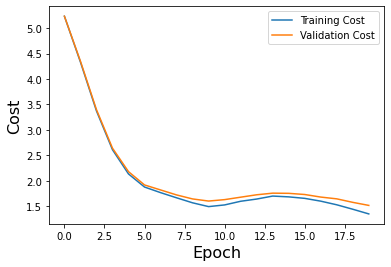

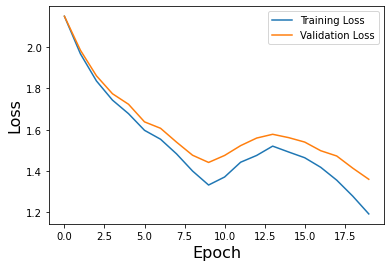

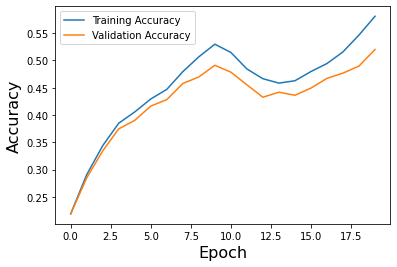

Final Accuracy: 0.5202


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:91: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [15]:
#9 layers w/ batch norm
nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], lmda = 0.005, batchNorm = True, he = True)
GDParams = [100, 1e-5, 1e-1, 20, 2250]
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()
plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()
plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()
print("Final Accuracy: " + str(nw.computeAccuracy(xValBig, lValBig)))


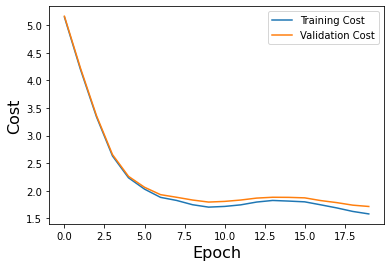

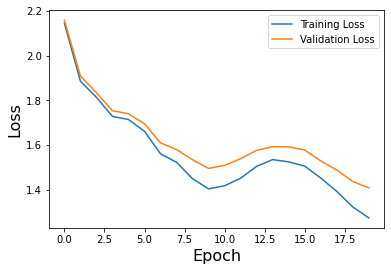

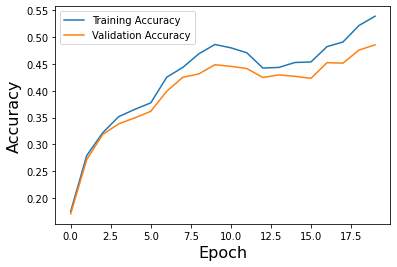

Final Accuracy: 0.4858


In [17]:
#9 layers w/o batch norm
nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], lmda = 0.005, batchNorm = False, he = True)
GDParams = [100, 1e-5, 1e-1, 20, 2250]
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()
plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()
plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()
print("Final Accuracy: " + str(nw.computeAccuracy(xValBig, lValBig)))


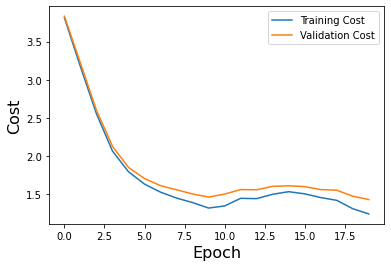

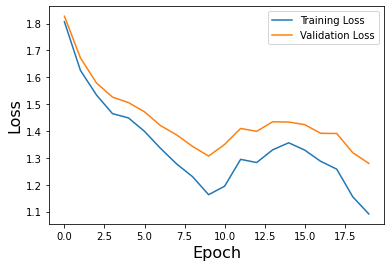

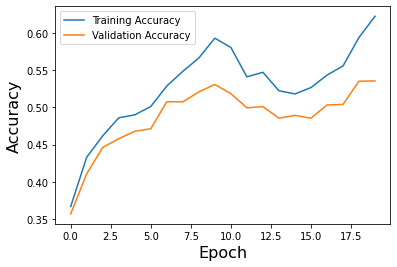

Final Accuracy: 0.5356


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:91: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [19]:
#3 layers w/ batch norm
nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.005, batchNorm = True, he = True)
GDParams = [100, 1e-5, 1e-1, 20, 2250]
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()
plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()
plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()
print("Final Accuracy: " + str(nw.computeAccuracy(xValBig, lValBig)))


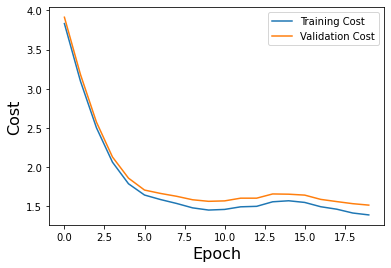

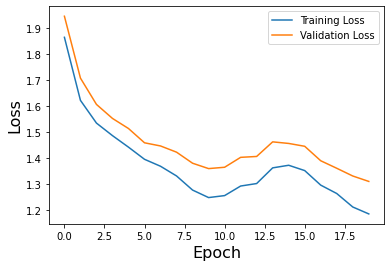

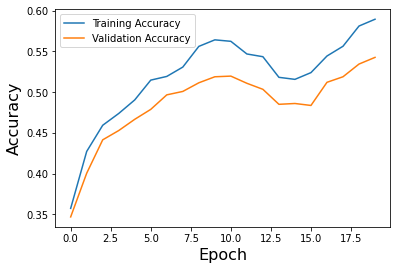

Final Accuracy: 0.5426


In [21]:
#3 layers w/o batch norm
nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.005, batchNorm = False, he = True)
GDParams = [100, 1e-5, 1e-1, 20, 2250]
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()
plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()
plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()
print("Final Accuracy: " + str(nw.computeAccuracy(xValBig, lValBig)))


In [24]:
GDParams = [100, 1e-5, 1e-1, 30, 2250]
lmdaGrid = np.power(10,np.random.uniform(-4,-2,10))

for lmda in lmdaGrid:
	nw = BNN([(50,3072),(50,50), (10,50)], lmda = lmda, batchNorm = True, he = True)
	nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)
	print("Final Accuracy for: " + str(nw.computeAccuracy(xValBig, lValBig)))
	print("For: " + str(lmda))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:84: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:91: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Final Accuracy for: 0.5426
For: 0.0008159936625320854
Final Accuracy for: 0.5494
For: 0.008130880511618586
Final Accuracy for: 0.5234
For: 0.0006582380425955684
Final Accuracy for: 0.5548
For: 0.002684823294606684
Final Accuracy for: 0.53
For: 0.00020490399538396616
Final Accuracy for: 0.5504
For: 0.006491610974622885
Final Accuracy for: 0.5212
For: 0.0004177330219057675
Final Accuracy for: 0.5202
For: 0.0001741401285663205
Final Accuracy for: 0.532
For: 0.0005344782367535189
Final Accuracy for: 0.518
For: 0.00013387698651689758


In [26]:
GDParams = [100, 1e-5, 1e-1, 30, 2250]
nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.002, batchNorm = True, he = True)
nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)
print("Final Accuracy: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Final Accuracy: 0.5313


In [27]:
GDParams = [100, 1e-5, 1e-1, 30, 2250]
nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.007, batchNorm = True, he = True)
nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)
print("Final Accuracy: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Final Accuracy: 0.5404


In [28]:
GDParams = [100, 1e-5, 1e-1, 20, 2250]
nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], lmda = 0.002, batchNorm = True, he = True)
nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)
print("Final Accuracy: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Final Accuracy: 0.5071


In [29]:
GDParams = [100, 1e-5, 1e-1, 20, 2250]
nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], lmda = 0.007, batchNorm = True, he = True)
nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)
print("Final Accuracy: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Final Accuracy: 0.5138


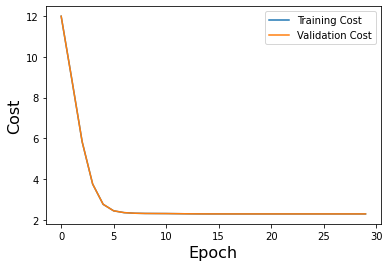

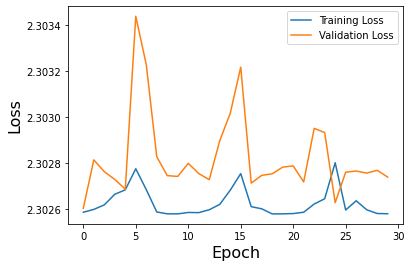

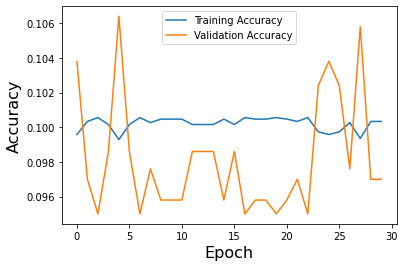

Final Accuracy for: 0.1


In [30]:
# 9-Layer w/o batch norm sig:1e-1
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], 
		 lmda = 0.007, batchNorm = False, he = False, sig = 1e-1)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


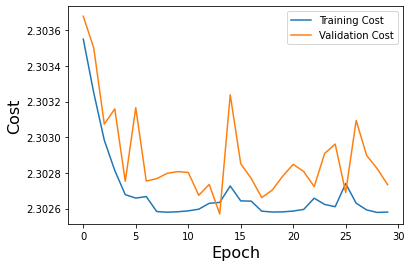

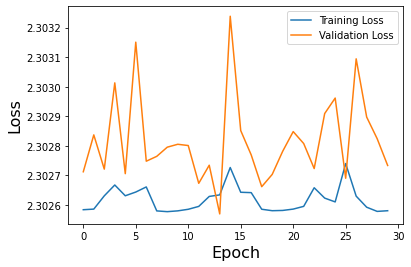

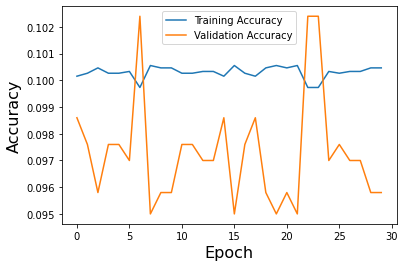

Final Accuracy for: 0.1


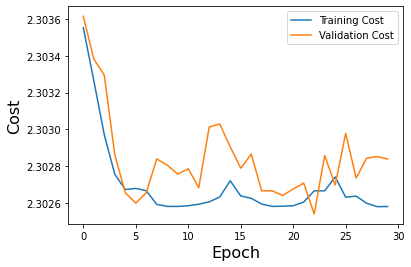

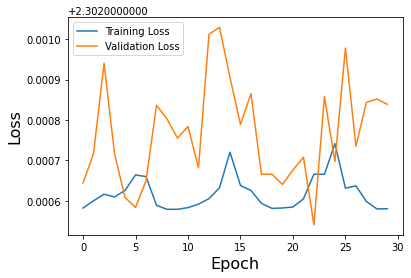

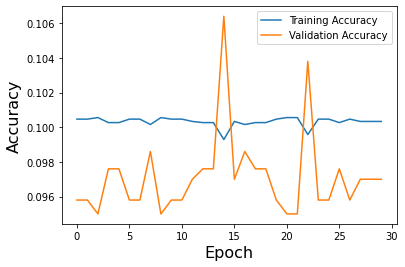

Final Accuracy for: 0.1


In [34]:
# 9-Layer w/o batch norm sig:1e-3
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], 
		 lmda = 0.007, batchNorm = False, he = False, sig = 1e-3)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


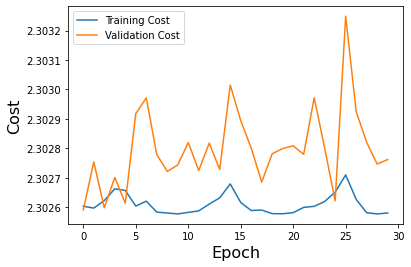

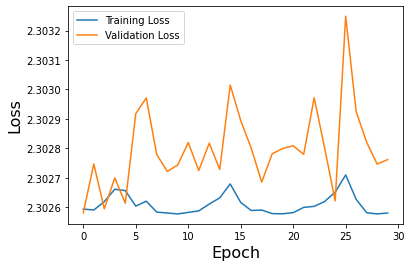

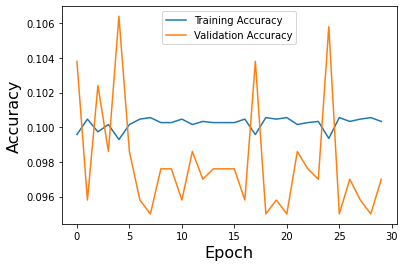

Final Accuracy for: 0.1


In [32]:
# 9-Layer w/o batch norm sig:1e-4
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], 
		 lmda = 0.007, batchNorm = False, he = False, sig = 1e-4)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


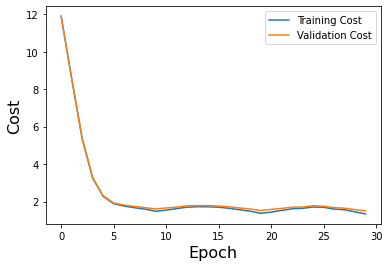

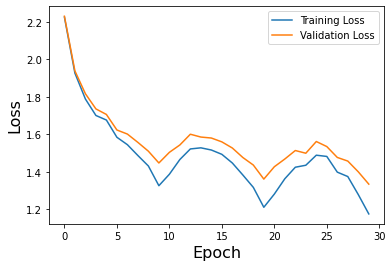

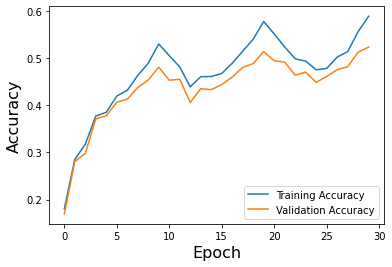

Final Accuracy for: 0.5287


In [33]:
# 9-layer w/ batchNorm sig:1e-1
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], 
		 lmda = 0.007, batchNorm = True, he = False, sig = 1e-1)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


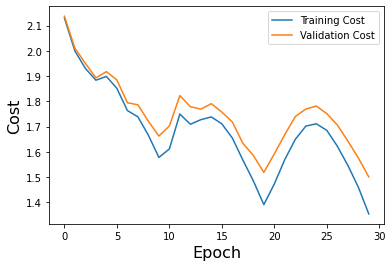

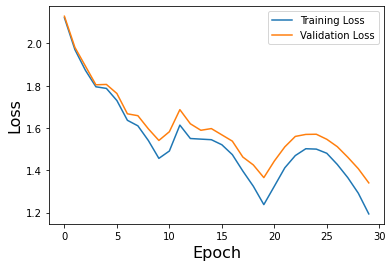

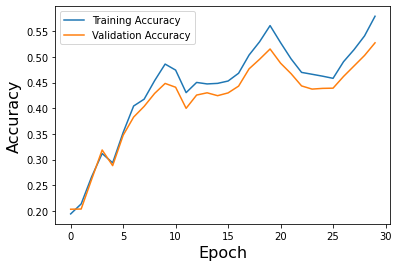

Final Accuracy for: 0.5096


In [35]:
# 9-layer w/ batchNorm sig:1e-3
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], 
		 lmda = 0.007, batchNorm = True, he = False, sig = 1e-3)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


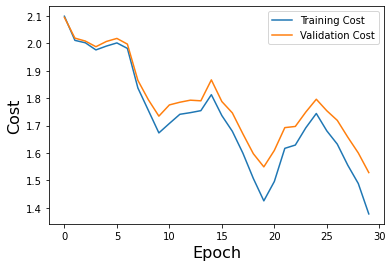

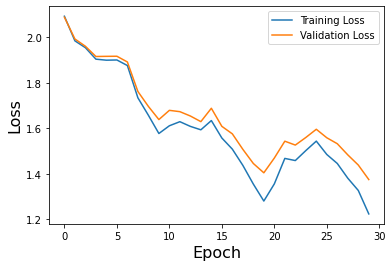

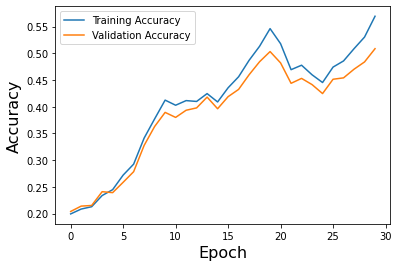

Final Accuracy for: 0.5051


In [36]:
# 9-layer w/ batchNorm sig:1e-4
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(30,50),(20,30),(20,20),(10,20),(10,10),(10,10),(10,10),(10,10)], 
		 lmda = 0.007, batchNorm = True, he = False, sig = 1e-4)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


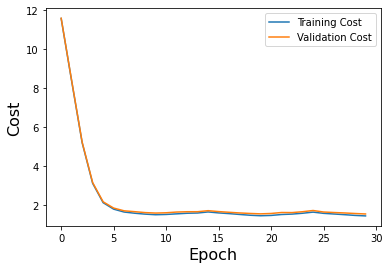

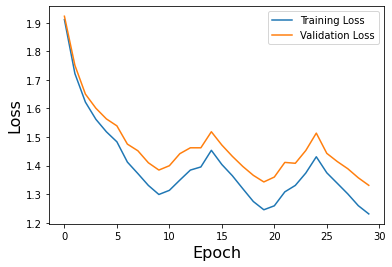

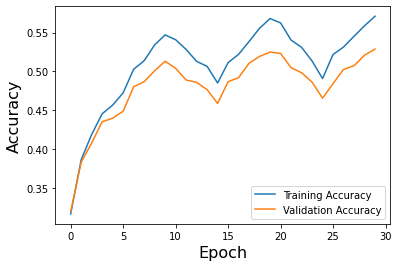

Final Accuracy for: 0.5301


In [40]:
# 3-Layer w/o batch norm sig:1e-1
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.007, batchNorm = False,he = False, sig = 1e-1)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


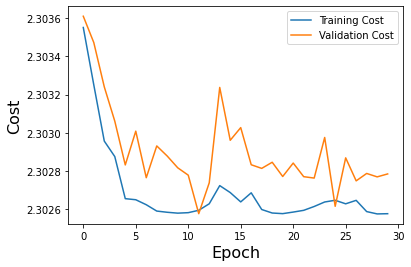

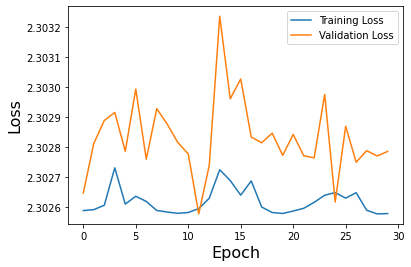

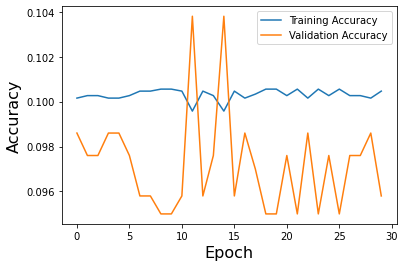

Final Accuracy for: 0.1


In [38]:
# 3-Layer w/o batch norm sig:1e-3
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.007, batchNorm = False,he = False, sig = 1e-3)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))

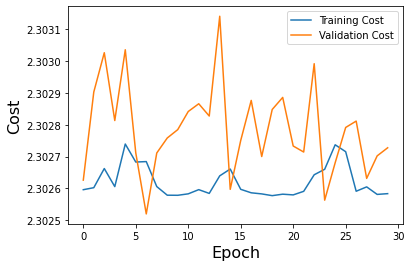

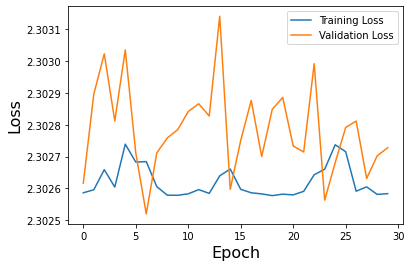

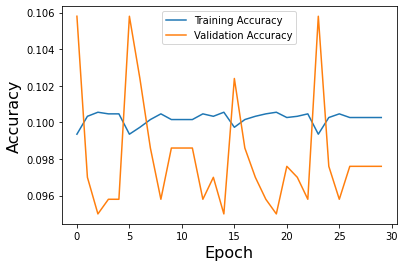

Final Accuracy for: 0.1


In [39]:
# 3-Layer w/o batch norm sig:1e-4
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.007, batchNorm = False,he = False, sig = 1e-4)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


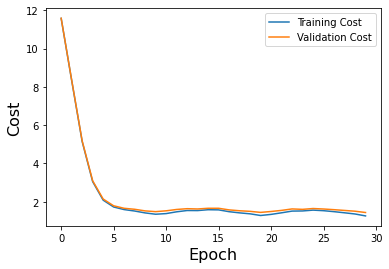

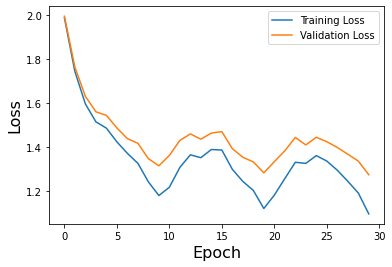

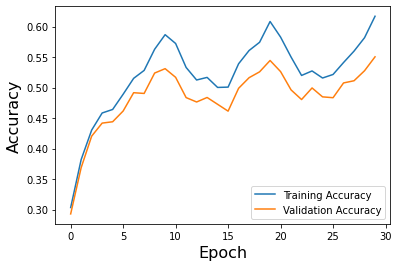

Final Accuracy for: 0.5379


In [41]:
# 3-Layer w/ batch norm sig:1e-1
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.007, batchNorm = True,he = False, sig = 1e-1)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


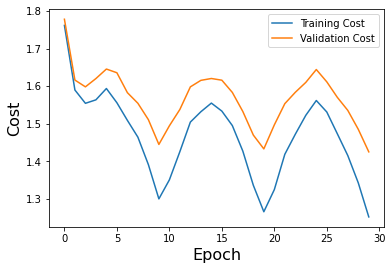

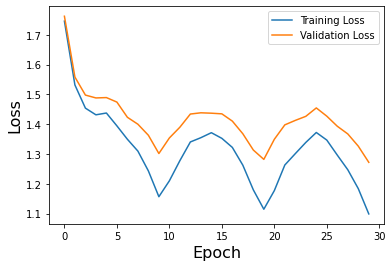

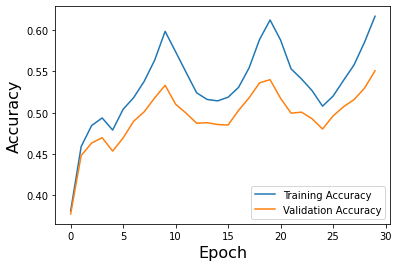

Final Accuracy for: 0.5359


In [42]:
# 3-Layer w/ batch norm sig:1e-3
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.007, batchNorm = True,he = False, sig = 1e-3)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


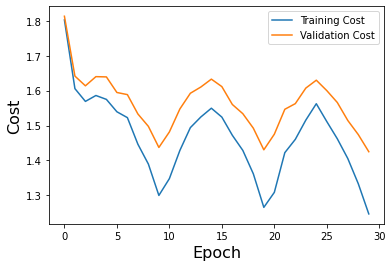

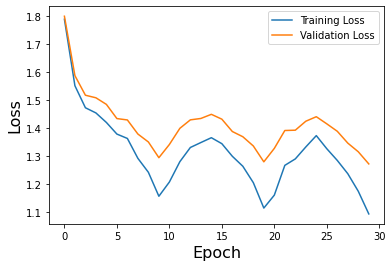

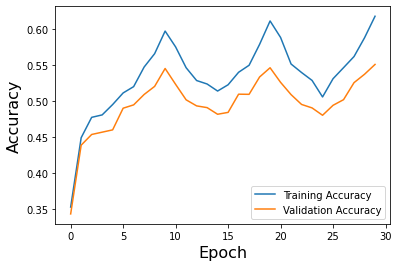

Final Accuracy for: 0.5381


In [43]:
# 3-Layer w/ batch norm sig:1e-4
GDParams = [100, 1e-5, 1e-1, 30, 2250]

nw = BNN([(50,3072),(50,50), (10,50)], lmda = 0.007, batchNorm = True,he = False, sig = 1e-4)
tc, vc, tl, vl, tac, vac = nw.miniBatchGD(xTrainBig, yTrainBig, GDParams, xValBig, yValBig)

plt.plot(tc, label = "Training Cost")
plt.plot(vc, label = "Validation Cost")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

plt.plot(tl, label = "Training Loss")
plt.plot(vl, label = "Validation Loss")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

plt.plot(tac, label = "Training Accuracy")
plt.plot(vac, label = "Validation Accuracy")
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

print("Final Accuracy for: " + str(nw.computeAccuracy(xTestBig, lTestBig)))